In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

plt.rcParams["figure.figsize"] = (20,10)

(2399,)
(2399, 2) (2399,)


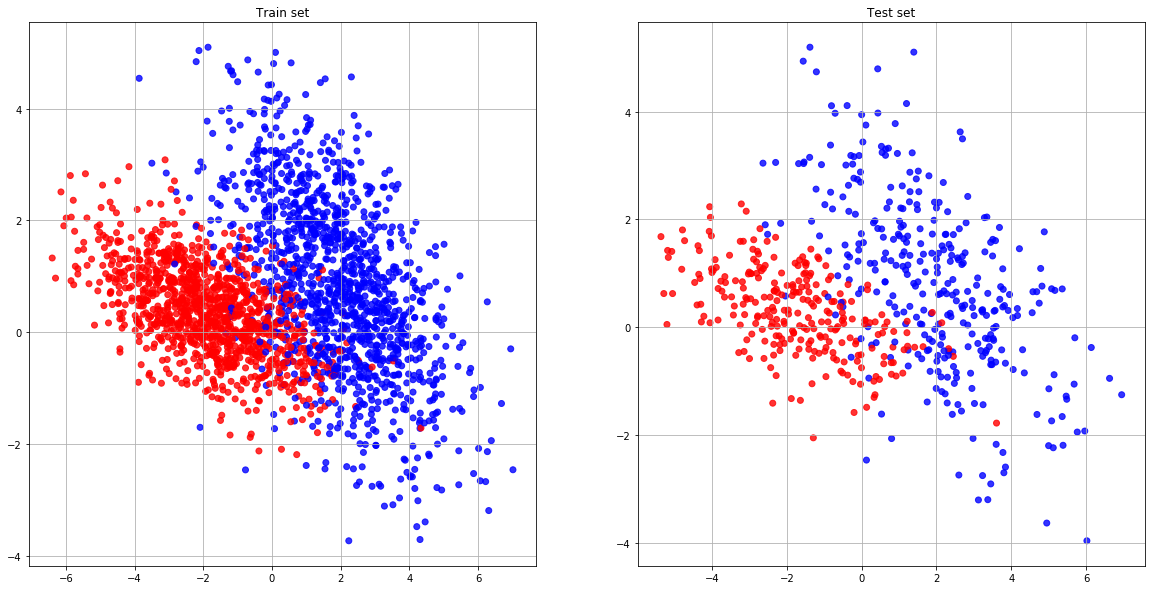

In [112]:
df = pd.read_csv('../lab2/2_features/9.csv')
X = df.iloc[:, 0:2].to_numpy()
y = df.iloc[:, 2].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(y_train.shape)

color_map = {0: 'red', 1: 'blue'}

_, (axs0, axs1) = plt.subplots(1, 2)
axs0.scatter(X_train[:, 0], X_train[:, 1], c=np.vectorize(color_map.get)(y_train), alpha=0.8);
axs0.set_title('Train set')
axs0.grid()

axs1.scatter(X_test[:, 0], X_test[:, 1], c=np.vectorize(color_map.get)(y_test), alpha=0.8);
axs1.set_title('Test set')
axs1.grid()

print(X_train.shape, y_train.shape)

# Добавим компоненту равную единице.
# N_train = X_train.shape[0]
# N_test = X_test.shape[0]
# X_train = np.hstack((np.ones((N_train, 1)), X_train))
# X_test = np.hstack((np.ones((N_test, 1)), X_test))

In [36]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(hidden_layer_sizes=(50,), max_iter=10, alpha=0.0,
                    solver='sgd', verbose=10, random_state=1, batch_size=200,
                    learning_rate_init=.1, momentum=0.0)

mlp.fit(X_train, y_train)
print("Training set score: %f" % mlp.score(X_train, y_train))
print("Test set score: %f" % mlp.score(X_test, y_test))

for coef in mlp.coefs_:
    print(coef.shape)


Iteration 1, loss = 0.43036293
Iteration 2, loss = 0.27488767
Iteration 3, loss = 0.23603862
Iteration 4, loss = 0.21663310
Iteration 5, loss = 0.20429409
Iteration 6, loss = 0.19588737
Iteration 7, loss = 0.18982687
Iteration 8, loss = 0.18536745
Iteration 9, loss = 0.18164801
Iteration 10, loss = 0.17884637
Training set score: 0.929971
Test set score: 0.925000
(2, 50)
(50, 1)


/home/asdor45/education/ML/env_lab/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [2]:
def logsig(x):
    return 1 / (1 + np.exp(-x))

def relu(x):
    return np.maximum(x, 0)

def softmax(x):
    tmp = x - x.max(axis=1)[:, np.newaxis]
    x = np.exp(tmp)
    x /= x.sum(axis=1)[:, np.newaxis]
    return x

ACTIVATIONS_MAP = {
    'logsig': logsig,
    'tanh': np.tanh,
    'relu': relu,
    'softmax': softmax
}


def logsig_deriv(z):
    return z * (1 - z)

def tanh_deriv(z):
    return 1 - z * z

def relu_deriv(z):
    return (z >= 0) * 1

DERIVATIVES_MAP = {
    'logsig': logsig_deriv,
    'tanh': tanh_deriv,
    'relu': relu_deriv
}


from scipy.special import xlogy

def squared_loss(y_true, y_pred):
    return np.sum((y_true - y_pred) ** 2) / 2

def cross_entropy_loss(y_true, y_pred):
#     print(y_pred)
    return -xlogy(y_true, y_pred).sum()

LOSS_MAP = {
    'squared': squared_loss,
    'cross_entropy': cross_entropy_loss
}


def batch_split(X, y, batch_size):
    data_size = y.size
    if batch_size == -1:
        batch_size = y.size
    
    packs_cnt = int(data_size / batch_size)
    X_batchs = np.array_split(X, packs_cnt)
    y_batchs = np.array_split(y, packs_cnt)
    return X_batchs, y_batchs

In [3]:
from sklearn.base import BaseEstimator
from sklearn.base import ClassifierMixin
from sklearn.utils.multiclass import check_classification_targets
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn.preprocessing import LabelBinarizer

class NNClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, hidden_layer_sizes=(50,), hidden_activation='relu', out_activation='softmax',
                 l_rate=1e-1, epocs=10, batch_size=-1, random_base=1, verbose=False, history=False):
        self.hidden_layer_sizes = hidden_layer_sizes
        self.hidden_activation = hidden_activation
        self.out_activation = out_activation
        self.l_rate = l_rate
        self.epocs = epocs
        self.batch_size = batch_size
        self.random_base = random_base
        self.verbose = verbose
        self.history = history

    def _init_weight(self, in_features, out_features):
        d = np.sqrt(3 / (in_features + 1))
        weights = np.random.RandomState(self.random_base).uniform(-d, d, (in_features, out_features))
        biases = np.random.RandomState(self.random_base).uniform(-d, d, out_features)
        return weights, biases    


    def _init_params(self, X, y):
        hidden_layer_sizes = list(self.hidden_layer_sizes)
        # output count
        self.n_out_ = y.shape[1]
        # layer sizes
        self.net_sizes_ = [X.shape[1]] + hidden_layer_sizes + [self.n_out_]
        # layer amount
        self.net_len_ = len(self.net_sizes_)
        
        self.weights_ = []
        self.biases_ = []
        
        for i in range(self.net_len_ - 1):
            weights, biases = self._init_weight(self.net_sizes_[i], self.net_sizes_[i + 1])
            self.weights_.append(weights)
            self.biases_.append(biases)
            
        # init loss function
        if self.out_activation == 'logsig':
            self.loss_func_ = LOSS_MAP['squared']
        else:
            self.loss_func_ = LOSS_MAP['cross_entropy']


    def _forward_pass(self, activations, weights, biases):
        hidden_activation = ACTIVATIONS_MAP[self.hidden_activation]
        
        for i in range(self.net_len_ - 1):
            activations[i + 1] = np.dot(activations[i], weights[i])
            activations[i + 1] += biases[i]
            
            # hidden layers
            if (i + 1) != (self.net_len_ - 1):
                activations[i + 1] = hidden_activation(activations[i + 1])
        
        # output layers
        out_activation = ACTIVATIONS_MAP[self.out_activation]
        activations[i + 1] = out_activation(activations[i + 1])
#         print('out_act: ', activations[i + 1].shape)

        return activations

    def _compute_grad(self, layer, n_samples, activations, deltas, weights_grads, biases_grads):
        weights_grads[layer] = np.dot(activations[layer].T, deltas[layer]) / n_samples
        biases_grads[layer] = np.mean(deltas[layer], 0)

        return weights_grads, biases_grads

    def _backprop(self, X, y, activations, deltas, weights_grads, biases_grads):
        n_samples = X.shape[0]
        loss_val = self.loss_func_(y, activations[-1])

        last_n = self.net_len_ - 2
        deltas[last_n] = activations[-1] - y

        if (self.out_activation == 'logsig'):
            out_deriv = DERIVATIVES_MAP[self.out_activation]
            deltas[last_n] *= out_deriv(activations[-1])

        weights_grads, biases_grads = self._compute_grad(last_n, n_samples, activations, deltas, weights_grads, biases_grads)

        for i in range(self.net_len_ - 2, 0, -1):
#             print(deltas[i].shape, self.weights_[i].T.shape)
            deltas[i - 1] = np.dot(deltas[i], self.weights_[i].T)
            deriv_fun = DERIVATIVES_MAP[self.hidden_activation]            
            deltas[i - 1] *= deriv_fun(activations[i])

            weights_grads, biases_grads = self._compute_grad(i - 1, n_samples, activations, deltas, weights_grads,
                                                             biases_grads)

        return loss_val, weights_grads, biases_grads       


    def fit(self, X, y):
        X, y = check_X_y(X, y, multi_output=True)
        check_classification_targets(y)

        if y.ndim == 1:
            y = y.reshape((-1, 1))
            
        from sklearn.preprocessing import OneHotEncoder
        self.label_binarizer_ = OneHotEncoder(handle_unknown='ignore')

        self.label_binarizer_.fit(y)
        y = self.label_binarizer_.transform(y).toarray()
        self._init_params(X, y)

        X_batchs, y_batchs = batch_split(X, y, self.batch_size)
        batch_cnt = len(y_batchs)
        eps = 1e-4
        
        activations = [X] + [None] * (self.net_len_ - 1)
        deltas = [None] * (len(activations) - 1)
        
        weights_grads = [np.empty((self.net_sizes_[i], self.net_sizes_[i + 1])) for i in range(self.net_len_ - 1)]
        biases_grads = [np.empty(self.net_sizes_[i + 1]) for i in range(self.net_len_ - 1)]
        self.params_history_ = []
        self.loss_curve_ = []

        for p_ in range(self.epocs):
            sum_loss = 0.0
            for i in range(batch_cnt):
                activations[0] = X_batchs[i]
                activations = self._forward_pass(activations, self.weights_, self.biases_)
                
                loss, weights_grads, biases_grads = self._backprop(X_batchs[i], y_batchs[i], activations, deltas, weights_grads, biases_grads)
                sum_loss += loss

                self.weights_ = [w - self.l_rate * grad for w, grad in zip(self.weights_, weights_grads)]
                self.biases_ = [b - self.l_rate * grad for b, grad in zip(self.biases_, biases_grads)]       

            sum_loss /= X.shape[0]
            self.loss_curve_.append(sum_loss)
            if self.history:
                self.params_history_.append((self.weights_, self.biases_))
                
#             self.accuracy_curve_.append(self.score(X, self.label_binarizer_.inverse_transform(y)))

            if self.verbose:
                print(f'Epoc: {p_}, loss: {sum_loss}')

        return self

    def predict(self, X, weights=None, biases=None):
        if weights is None:
            weights = self.weights_
        
        if biases is None:
            biases = self.biases_

        check_is_fitted(self, [])
        X = check_array(X)

        activations = [X]
        for i in range(self.net_len_ - 1):
            activations.append(np.empty((X.shape[0], self.net_sizes_[i + 1])))

        # forward propagate
        self._forward_pass(activations, weights, biases)
        y_pred = activations[-1]
        
        if self.n_out_ == 1:
            y_pred = y_pred.ravel()

        return self.label_binarizer_.inverse_transform(y_pred)
    
    def score(self, X, y, weights=None, biases=None):
        from sklearn.metrics import accuracy_score
        return accuracy_score(y, self.predict(X, weights, biases))
    
    def accuracy_curve(self, X, y):
        if y.ndim == 1:
            y = y.reshape((-1, 1))
        y = self.label_binarizer_.transform(y).toarray()
        accuracy = []

        for w, b in self.params_history_:
            y_trans = self.label_binarizer_.inverse_transform(y)
            accuracy.append(self.score(X, y_trans, w, b))

        return accuracy


from sklearn.utils.estimator_checks import check_estimator
# check_estimator(MLPClassifier)

In [4]:
nn = NNClassifier(hidden_layer_sizes=(50,), batch_size=100,  epocs=10, out_activation='logsig',
                  verbose=True, l_rate=0.1, history=True)
clf = nn.fit(X_train, y_train)

plt.plot(clf.accuracy_curve(X_train, y_train))
plt.plot(clf.accuracy_curve(X_test, y_test))
# accuracy_curve
# plt.plot(clf.loss_curve_)

NameError: name 'X_train' is not defined

In [203]:
def plot_stat(hidden_activation, N_epocs=200):
    def _help_plot(axes, hidden, output):
        b_clf = lambda x: NNClassifier(hidden_layer_sizes=(x,), batch_size=100,  epocs=N_epocs, random_base=1,
                                       hidden_activation=hidden, out_activation=output, l_rate=0.1, history=True)
        clfs = [b_clf(i) for i in [2, 8, 16]]
        accs = dict()
        for clf in clfs:
            hn_size = clf.hidden_layer_sizes[0]
            clf.fit(X_train, y_train)
            axes[0].plot(clf.loss_curve_, label=f'hidden neurons= {hn_size}')
            axes[0].grid()
            axes[0].set_xlabel('epocs')
            axes[0].set_ylabel('Error')
            axes[0].set_title(f'Error: {hidden_activation} + {output}')
            axes[0].legend()
            
            accuracy_curve = clf.accuracy_curve(X_test, y_test)
#             print(accuracy_curve)
            axes[1].plot(accuracy_curve, label=f'hidden neurons = {hn_size}')
            axes[1].grid()
            axes[1].set_xlabel('epocs')
            axes[1].set_ylabel('Accuracy')
            axes[1].set_title(f'Train accuracy: {hidden_activation} + {output}')
            axes[1].legend()
            
            accs[hn_size] = accuracy_curve[-1]
        
        best_hn = max(accs, key=accs.get)            
        print(f'Best accuracy for {hidden} + {output}, hidden neurons = {best_hn}: {accs[best_hn]:.3f}')


    _, axs = plt.subplots(2, 2)
    _help_plot(axs[0], hidden_activation, 'logsig')
    _help_plot(axs[1], hidden_activation, 'softmax')


Best accuracy for relu + logsig, hidden neurons = 16: 0.940
Best accuracy for relu + softmax, hidden neurons = 16: 0.942


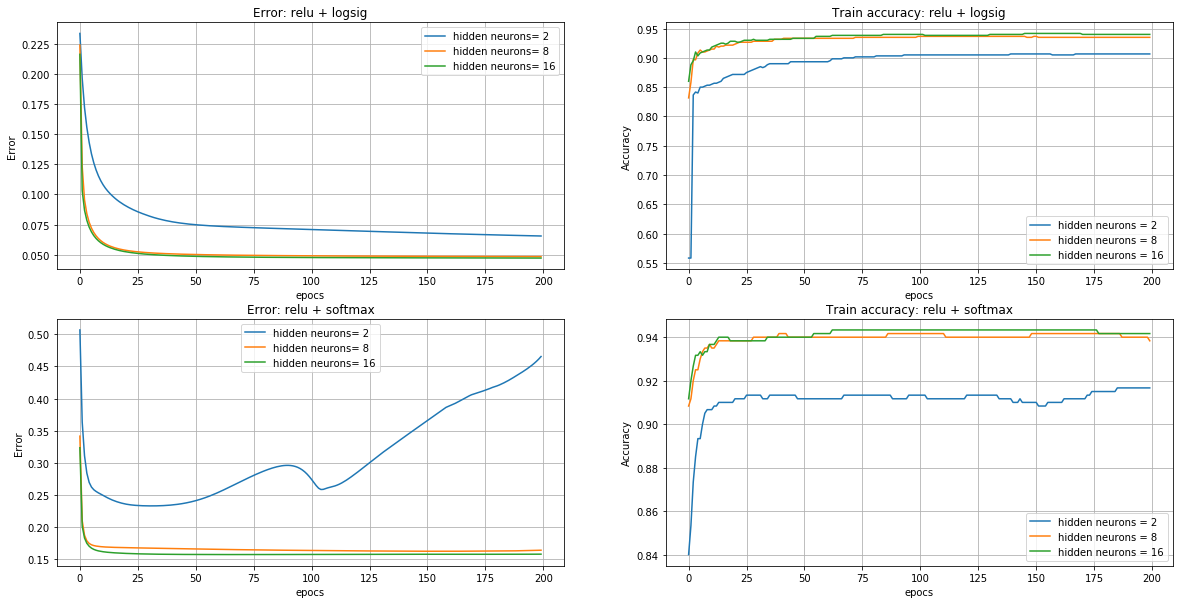

In [204]:
plot_stat('relu', N_epocs=200)

Best accuracy for logsig + logsig, hidden neurons = 16: 0.923
Best accuracy for logsig + softmax, hidden neurons = 8: 0.937


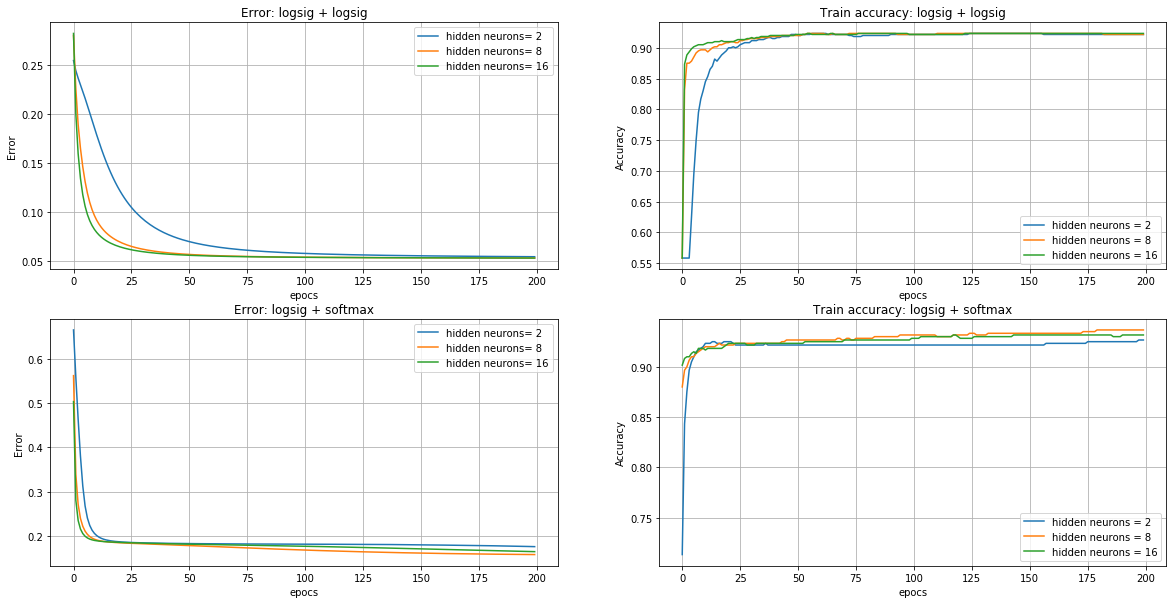

In [205]:
plot_stat('logsig', N_epocs=200)

Best accuracy for tanh + logsig, hidden neurons = 16: 0.937
Best accuracy for tanh + softmax, hidden neurons = 2: 0.942


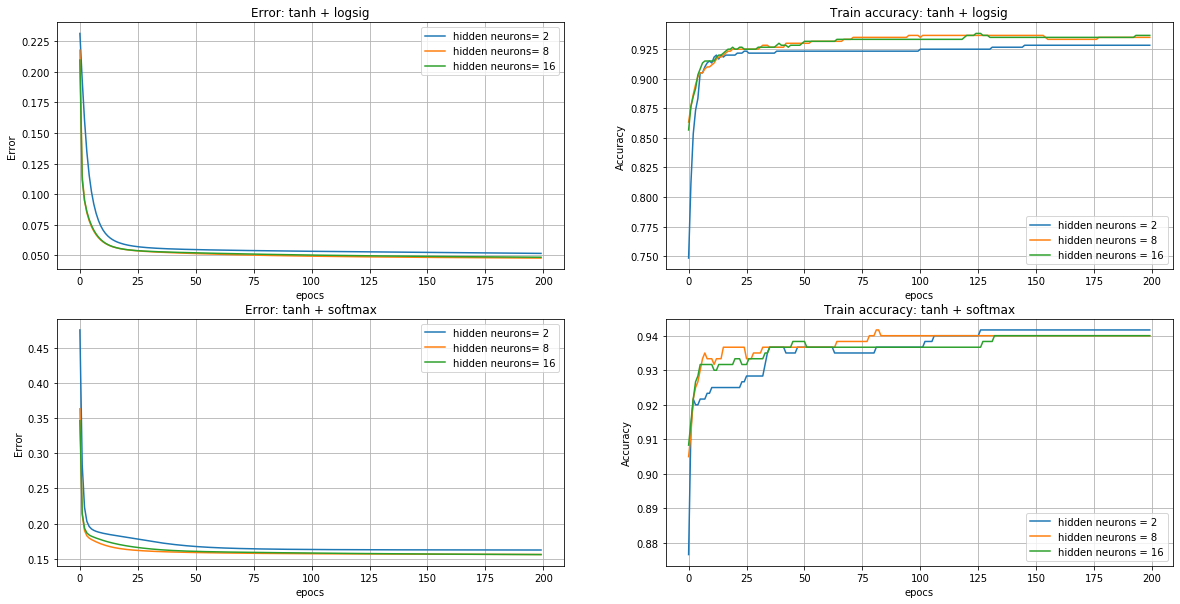

In [206]:
plot_stat('tanh', N_epocs=200)

In [5]:
from skimage.io import imread
import os

X_mnist = []
y_mnist = []

for root, dirs, files in os.walk('../lab3/notMNIST/'):
    for im in files:
        label = os.path.dirname(os.path.join(root, im))[-1]
        image = imread(os.path.join(root, im))
        X_mnist.append(image)
        y_mnist.append(label)

num_samples = len(X_mnist)
print('Number of images: ', num_samples)

Number of images:  18724


Train set:  (14979, 784) (14979,)
Test set:  (3745, 784) (3745,)


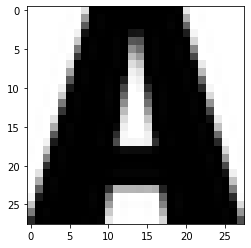

In [6]:
X = np.asarray(X_mnist, dtype=np.float).reshape((num_samples, -1))
y = np.asarray(y_mnist)

X /= 255

# print(X[0])
plt.imshow(X[10000].reshape((28, 28)), cmap='Greys')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print('Train set: ', X_train.shape, y_train.shape)
print('Test set: ', X_test.shape, y_test.shape)

In [84]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(hidden_layer_sizes=(4096,), max_iter=100, alpha=0.0, momentum=0,
                    solver='sgd', verbose=10, random_state=1, batch_size=3000,
                    learning_rate_init=.1)

mlp.fit(X_train, y_train)
print("Training set score: %f" % mlp.score(X_train, y_train))
print("Test set score: %f" % mlp.score(X_test, y_test))

# for coef in mlp.coefs_:
#     print(coef.shape)

# for inter in mlp.intercepts_:
#     print(inter.shape)


Iteration 1, loss = 1.94078111
Iteration 2, loss = 1.15798298
Iteration 3, loss = 0.80532057
Iteration 4, loss = 0.65771678
Iteration 5, loss = 0.57558858
Iteration 6, loss = 0.53867072
Iteration 7, loss = 0.51197096
Iteration 8, loss = 0.49378817
Iteration 9, loss = 0.47922575
Iteration 10, loss = 0.46690181
Iteration 11, loss = 0.45597956
Iteration 12, loss = 0.44743428
Iteration 13, loss = 0.43937110
Iteration 14, loss = 0.43225167
Iteration 15, loss = 0.42581228
Iteration 16, loss = 0.42033162
Iteration 17, loss = 0.41535046
Iteration 18, loss = 0.41049510
Iteration 19, loss = 0.40661093
Iteration 20, loss = 0.40231861
Iteration 21, loss = 0.39835844
Iteration 22, loss = 0.39456535
Iteration 23, loss = 0.39210656
Iteration 24, loss = 0.38813634
Iteration 25, loss = 0.38521412
Iteration 26, loss = 0.38226318
Iteration 27, loss = 0.38034984
Iteration 28, loss = 0.37642032
Iteration 29, loss = 0.37392495
Iteration 30, loss = 0.37244948
Iteration 31, loss = 0.37025172
Iteration 32, los

/home/asdor45/education/ML/env_lab/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Training set score: 0.926430
Test set score: 0.905474


Epoc: 0, loss: 1.083347869409908
Epoc: 1, loss: 0.4540930861887258
Epoc: 2, loss: 0.4087702061039061
Epoc: 3, loss: 0.38347530203536867
Epoc: 4, loss: 0.3656941362723211
Epoc: 5, loss: 0.35182347929123187
Epoc: 6, loss: 0.3403468132074806
Epoc: 7, loss: 0.33049399870795526
Epoc: 8, loss: 0.32181901904649884
Epoc: 9, loss: 0.3140460245024566
Epoc: 10, loss: 0.3069869921412117
Epoc: 11, loss: 0.3005087388693368
Epoc: 12, loss: 0.2945116681893826
Epoc: 13, loss: 0.28892370357312175
Epoc: 14, loss: 0.2836886008223196
Epoc: 15, loss: 0.2787583517548153
Epoc: 16, loss: 0.27409685216386764
Epoc: 17, loss: 0.2696746638322158
Epoc: 18, loss: 0.2654664238440196
Epoc: 19, loss: 0.2614512989065377
Epoc: 20, loss: 0.25761081629090116
Epoc: 21, loss: 0.25392977061486394
Epoc: 22, loss: 0.2503953310322622
Epoc: 23, loss: 0.24699529946242643
Epoc: 24, loss: 0.24371786460200764
Epoc: 25, loss: 0.2405549685991442
Epoc: 26, loss: 0.23749856375087933
Epoc: 27, loss: 0.23454099463323047
Epoc: 28, loss: 0.2

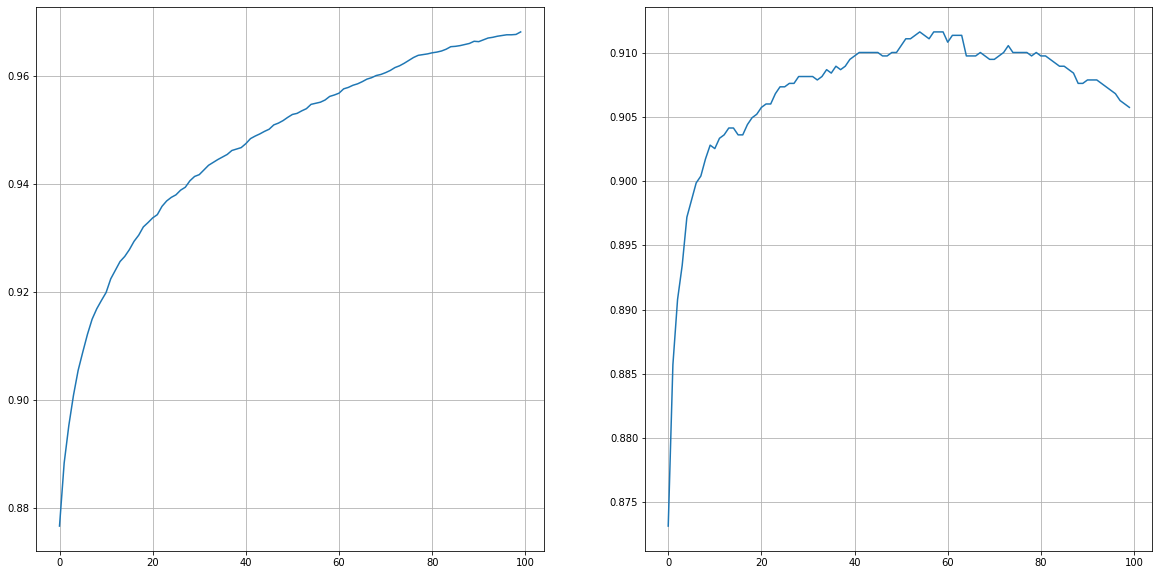

In [11]:
mlp = NNClassifier(hidden_layer_sizes=(4096,), epocs=100, verbose=True, random_base=1, batch_size=3000,
                   hidden_activation='relu', out_activation='softmax', l_rate=.1, history=True)

mlp.fit(X_train, y_train)
print("Training set score: %f" % mlp.score(X_train, y_train))
print("Test set score: %f" % mlp.score(X_test, y_test))

_, (ax0, ax1) = plt.subplots(1, 2)
ax0.plot(mlp.accuracy_curve(X_train, y_train))
ax0.grid()

ax1.plot(mlp.accuracy_curve(X_test, y_test))
ax1.grid()

for weight in mlp.weights_:
    print(weight.shape)

In [101]:
from sklearn.model_selection import GridSearchCV

def get_best_model(estimator, param_grid):

    grid_model = GridSearchCV(estimator, param_grid=param_grid, n_jobs=-1, cv=3)
    grid_model.fit(X_train, y_train)
    best_model = grid_model.best_estimator_

    print(f'Best params: {grid_model.best_params_}')
    print(f'Train accuracy: {best_model.score(X_train, y_train)}')
    print(f'Test accuracy: {best_model.score(X_test, y_test)}')
    
    return best_model

In [103]:
params = {
    'l_rate': np.geomspace(1e-2, 1, 10)
}

mlp_model = NNClassifier(hidden_layer_sizes=(50,), epocs=10, verbose=False, random_base=1, batch_size=3000,
                   hidden_activation='relu', out_activation='softmax')
l_rate_best_model = get_best_model(mlp_model, params)

Best params: {'l_rate': 0.1291549665014884}
Train accuracy: 0.8970558782295214
Test accuracy: 0.8854472630173564


In [206]:
from sklearn.datasets import make_multilabel_classification
from sklearn.neural_network import MLPClassifier

X, y = make_multilabel_classification(n_samples=10, n_classes=3, n_features=2,n_labels=1, random_state=1)
print(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.4, random_state=42)
clf = MLPClassifier(alpha=1, max_iter=1000).fit(X_train, y_train)
print(clf.predict(X_test))
print(y_train)

[[19. 29.]
 [15. 37.]
 [33. 26.]
 [38. 26.]
 [29. 26.]
 [24. 17.]
 [25.  9.]
 [26. 20.]
 [31. 20.]
 [16. 38.]]
[[0 0 0]
 [0 1 0]
 [0 0 0]
 [0 1 0]]
[[0 0 0]
 [0 0 0]
 [0 1 0]
 [0 0 0]
 [0 0 0]
 [1 0 0]]


/home/asdor45/education/ML/env_lab/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [45]:
from sklearn import preprocessing
lb = preprocessing.LabelBinarizer()
lb.fit([0, 1])
result_2d = np.array([[item[0], 0 if item[0] else 1] for item in a])
print(lb.y_type_)
# lb.transform([0, 1])
# lb.inverse_transform(np.array([[0, 1, 0], [1, 0, 0]]))
lb.inverse_transform(np.array([[0.6, 0.4]]))

binary


array([0])

In [91]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore')
enc.fit([[0], [1], [0]])
print(enc.categories_)
print(enc.transform([[0], [1]]).toarray())
print(enc.inverse_transform([
    [0.9, 0.1],
    [0, 1],
    [0, 1]
]))
# >>> enc.transform([['Female', 1], ['Male', 4]]).toarray()
# array([[1., 0., 1., 0., 0.],
#        [0., 1., 0., 0., 0.]])
# >>> enc.inverse_transform([[0, 1, 1, 0, 0], [0, 0, 0, 1, 0]])

[array([0, 1])]
[[1. 0.]
 [0. 1.]]
[[0]
 [1]
 [1]]
